In [1]:
# visualize the boxplot of the training experiment
import os.path as osp
import os
import numpy as np
import pandas as pd
import json
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# 1. 5 models fine-tuned or trained on STF dataset
# 2. 5 models trained on diff dataset without fine-tuning
# 3. all models in comparisons

In [3]:
# specify the model paths
metrics_root = "/labs/gevaertlab/users/yyhhli/code/vae/EDA/training_exp_eval/results"
prefix = "TRAINING_EXPS_V2-"
# fine-tuned or trained on STF dataset
model_paths_v1 = [
    'lidc->stf_4e-6_step5000_version-4.json',
    'lndb->stf_4e-6_step5000_version-1.json',
    'lidc-lndb->stf_4e-6_step5000_version-2.json',
    'stf-aug_8-32-128-512_1e-5_step65000_version-2.json',
    ]
# trained on diff dataset without fine-tuning
model_paths_v2 = [
    'lidcaug_8-32-128-512_1e-5_step65000_version-3.json',
    'lndb->stf_4e-6_step5000_version-1.json',
    'lidc-lndb-aug_8-32-128-512_1e-5_step65000_version-2.json',
    'lidc-lndb-stf-aug_8-32-128-512_1e-5_step65000_version-1.json',
    'stf-aug_8-32-128-512_1e-5_step65000_version-2.json',
    ]
# all models in comparisons
# model_paths_v3 = [
#     'TRAINING_EXPS_V2-lndb->stf_4e-6_step5000_version-1.json',
#     'TRAINING_EXPS_V2-lidcaug_8-32-128-512_1e-5_step65000_version-3.json',
#     'TRAINING_EXPS_V2-lidc-lndb-aug_8-32-128-512_1e-5_step65000_version-2.json',
#     'TRAINING_EXPS_V2-stf-aug_8-32-128-512_1e-5_step65000_version-2.json',
#     'TRAINING_EXPS_V2-lidc-lndb-stf-aug_8-32-128-512_1e-5_step65000_version-1.json',
#     'TRAINING_EXPS_V2-lndb-aug_8-32-128-512_1e-5_step65000_version-1.json',
#     'TRAINING_EXPS_V2-lidc->stf_4e-6_step5000_version-4.json',
#     'TRAINING_EXPS_V2-lidc-lndb->stf_4e-6_step5000_version-2.json',
#     'VAE3D32AUG_version-70.json'
#     ]

In [4]:
# load the data
def load_training_recon_metrics(metric_path, name):
    with open(metric_path, 'r') as f:
        metrics = json.load(f)
    return metrics[name]['values']


In [5]:
# loading
model_names = ["LIDC", "LNDb", "LIDC-LNDb", "STF"]
result = {}
for i, file_ext in enumerate(model_paths_v1):
    print(file_ext)
    model_path = osp.join(metrics_root, prefix + file_ext)
    metrics = load_training_recon_metrics(model_path, 'SSIM')
    result[model_names[i]] = metrics
result_df = pd.DataFrame(result)

lidc->stf_4e-6_step5000_version-4.json
lndb->stf_4e-6_step5000_version-1.json
lidc-lndb->stf_4e-6_step5000_version-2.json
stf-aug_8-32-128-512_1e-5_step65000_version-2.json


In [6]:
sys.path.insert(1, "/labs/gevaertlab/users/yyhhli/code/vae/")
from utils.visualization import vis_result_boxplot, vis_result_violin_plot

/labs/gevaertlab/users/yyhhli/miniconda3/envs/lungvae38/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


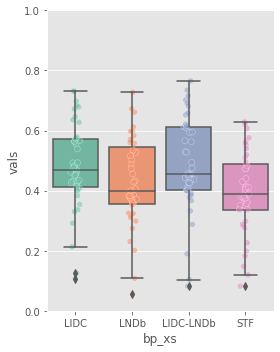

<AxesSubplot:xlabel='bp_xs', ylabel='vals'>

In [7]:
# make a plot to view
%matplotlib inline
vis_result_boxplot(result_df)

In [8]:
import math
import os
import os.path as osp
from typing import Dict, Union

# import cv2
import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import SimpleITK as sitk
import torchvision.utils as vutils
from umap.umap_ import UMAP
import umap.plot
from matplotlib.patches import Patch
# from matplotlib.ticker import MultipleLocator, ScalarFormatter
from mpl_toolkits import axisartist
from mpl_toolkits.axes_grid1 import host_subplot
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from statannot import add_stat_annotation



def make_snsdata(data: Union[np.ndarray, pd.DataFrame],
                 label: Union[None, np.ndarray, list] = None,):
    """
    make sns dataframe from data and label
    Args:
        data: numpy array or pandas dataframe
        label: numpy array or list, only used if data is numpy array
    Returns:
        sns dataframe
    """
    # data: col = [model1, model2, ...]; rows = [repeat1, repeat2, ...]
    if isinstance(data, np.ndarray):
        data = pd.DataFrame(data, label)
    # construct sns data
    vals, names, xs, bp_xs = [], [], [], []  # bp_xs: boxplot xs
    for i, col in enumerate(data.columns):
        vals += list(data[col])
        names += [col] * len(data[col])
        bp_xs += [i + 1] * len(data[col])
        xs += list(np.random.normal(i, 0.04, data[col].values.shape[0]))  # + 1
        # adds jitter to the data points - can be adjusted
    sns_data = pd.DataFrame(
        {'names': names, 'xs': xs, "bp_xs": bp_xs, 'vals': vals})
    return sns_data


def vis_result_violin_plot(data, save_path=None, box_pairs=None,
                           xlabel=None, ylabel=None, ylim=True, figsize=(4, 5)):
    """
    Args:
        data: pandas dataframe cols=model_names, rows=metrics
        save_path: path to save the figure
        box_pairs: list of tuples, each tuple is (model1, model2)
        xlabel: xlabel
        ylabel: ylabel
        ylim: ylim
        figsize: figsize
    Returns:
        ax: matplotlib axis
    """
    # construct sns data
    sns_data = make_snsdata(data)

    fig, ax = plt.subplots(1, 1, figsize=figsize)
    sns.set_style("whitegrid")
    if ylim is True:
        ylim = (0, 1)
    if ylim:
        plt.ylim(ylim)

    plt.xticks(np.arange(0, len(data.columns)),
               data.columns, rotation=0)  # + 1

    sns.violinplot(x='names', y='vals', hue='names', 
                   dodge=False,
                   data=sns_data, palette="Set2", ax=ax,
                   alpha=0.5)

    # no need to show legend
    ax.legend().set_visible(False)
    # add titles
    if xlabel is not None:
        plt.xlabel(xlabel, fontsize=10)
    if ylabel is not None:
        plt.ylabel(ylabel, fontsize=10)
    fig = plt.gcf()
    plt.tight_layout()
    if save_path is not None:
        fig.savefig(save_path, dpi=400)
        print(f"saved to {save_path}")
    plt.show()
    plt.close()
    return ax

In [9]:
# loading
model_names = ["LIDC", "LNDb", "LIDC-LNDb", "STF"]
result = {}
for i, file_ext in enumerate(model_paths_v1):
    print(file_ext)
    model_path = osp.join(metrics_root, prefix + file_ext)
    metrics = load_training_recon_metrics(model_path, 'SSIM')
    result[model_names[i]] = metrics
result_df = pd.DataFrame(result)

lidc->stf_4e-6_step5000_version-4.json
lndb->stf_4e-6_step5000_version-1.json
lidc-lndb->stf_4e-6_step5000_version-2.json
stf-aug_8-32-128-512_1e-5_step65000_version-2.json


saved to results/violin_plot_ssim_models_v1.jpeg


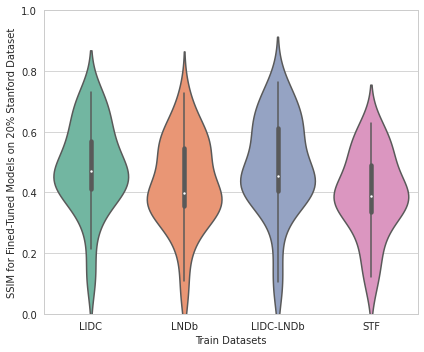

<AxesSubplot:xlabel='Train Datasets', ylabel='SSIM for Fined-Tuned Models on 20% Stanford Dataset'>

In [10]:
vis_result_violin_plot(result_df, xlabel="Train Datasets", ylabel="SSIM for Fined-Tuned Models on 20% Stanford Dataset", figsize=(6, 5), 
                       save_path="results/violin_plot_ssim_models_v1.jpeg")

In [11]:
model_names = ["LIDC", "LNDb", "LIDC-LNDb", "LIDC-LNDb-STF", "STF"]
result = {}
for i, file_ext in enumerate(model_paths_v2):
    print(file_ext)
    model_path = osp.join(metrics_root, prefix + file_ext)
    metrics = load_training_recon_metrics(model_path, 'SSIM')
    result[model_names[i]] = metrics
result_df = pd.DataFrame(result)

lidcaug_8-32-128-512_1e-5_step65000_version-3.json
lndb->stf_4e-6_step5000_version-1.json
lidc-lndb-aug_8-32-128-512_1e-5_step65000_version-2.json
lidc-lndb-stf-aug_8-32-128-512_1e-5_step65000_version-1.json
stf-aug_8-32-128-512_1e-5_step65000_version-2.json


saved to results/violin_plot_ssim_models_v2.jpeg


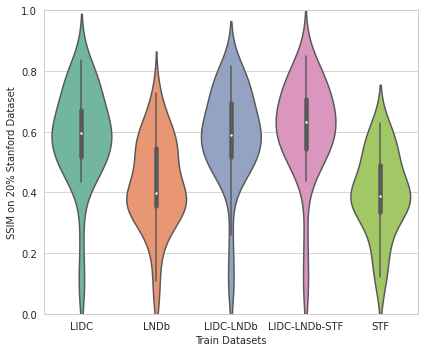

<AxesSubplot:xlabel='Train Datasets', ylabel='SSIM on 20% Stanford Dataset'>

In [12]:
vis_result_violin_plot(result_df, xlabel="Train Datasets", ylabel="SSIM on 20% Stanford Dataset", figsize=(6, 5), 
                       save_path="results/violin_plot_ssim_models_v2.jpeg")